<a href="https://colab.research.google.com/github/WinC3/SDSS-Datathon-2025/blob/main/XGBoostTreeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install scikit-learn pandas numpy graphviz

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from geopy.distance import geodesic

In [4]:
from google.colab import files
uploaded = files.upload()

Saving xgboost-data.csv to xgboost-data.csv


In [12]:
# Load dataset (Upload or use Google Drive)
df = pd.read_csv("xgboost-data.csv")  # Replace with actual dataset

# Drop columns that contain 'N/A' (NaN) in any row
df.dropna(axis=1, how='any', inplace=True)

# Drop ID column
df.drop(columns=["id_"], inplace=True, errors='ignore')

# Convert "DEN" from "Yes"/"No" to 1/0
if "DEN" in df.columns:
    df["DEN"] = df["DEN"].map({"YES": 1, "No": 0})

# Convert "size" from "0-499 sqft" format to separate min and max columns
def extract_size_range(size_str):
    if isinstance(size_str, str) and "-" in size_str:
        size_range = size_str.split(" sqft")[0].split("-")  # Remove "sqft" and split range
        return int(size_range[0]), int(size_range[1])
    return np.nan, np.nan  # Handle unexpected formats

if "size" in df.columns:
    df["size_min"], df["size_max"] = zip(*df["size"].apply(extract_size_range))
    df.drop(columns=["size"], inplace=True)  # Drop original 'size' column

# Drop rows where size couldn't be converted (if any)
df.dropna(subset=["size_min", "size_max"], inplace=True)

# One-hot encode categorical features (exposure & ward)
if "exposure" in df.columns:
    df = pd.get_dummies(df, columns=["exposure"])
if "ward" in df.columns:
    df = pd.get_dummies(df, columns=["ward"])
if "parking" in df.columns:
    df = pd.get_dummies(df, columns=["parking"])

# Define features and target
X = df.drop(columns=["price"]).values  # Features
y = df["price"].values  # Target
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle Missing Values in X_train and X_test
imputer = SimpleImputer(strategy="median")  # Use median for robustness
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


XGBoost Training MAE: $85,082.65
XGBoost Training MAPE: 10.35%
XGBoost Test MAE: $107,633.34
XGBoost Test MAPE: 11.59%


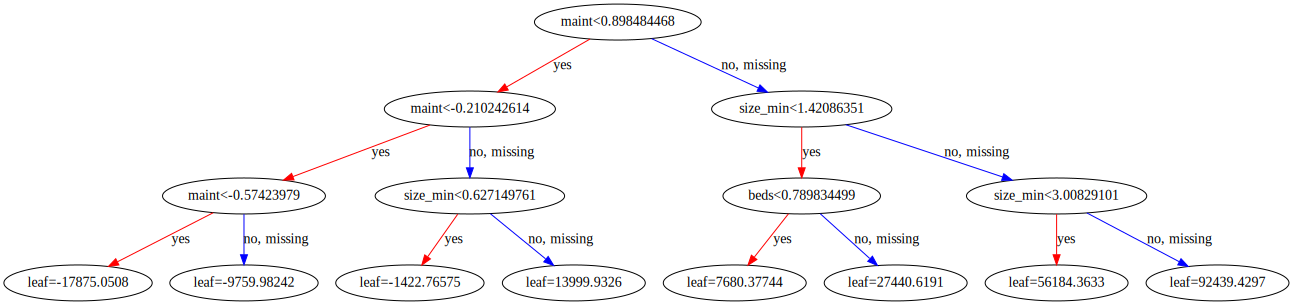

In [23]:
from xgboost import XGBRegressor
# Train XGBoost model
model = XGBRegressor(
    n_estimators=500,  # Number of trees (increase if needed)
    learning_rate=0.05,  # Step size (reduce if unstable)
    max_depth=3,  # Depth of each tree (increase if underfitting)
    subsample=0.8,  # Use 80% of data per tree (reduces overfitting)
    colsample_bytree=0.8,  # Use 80% of features per tree
    random_state=42
)
model.fit(X_train, y_train)

# Predict on training data
y_pred = model.predict(X_train)

# Calculate MAE
mae = mean_absolute_error(y_train, y_pred)
print(f"XGBoost Training MAE: ${mae:,.2f}")

mape = np.mean(np.abs((y_train - y_pred) / y_train)) * 100
print(f"XGBoost Training MAPE: {mape:.2f}%")

# Predict on test data
y_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost Test MAE: ${mae:,.2f}")

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"XGBoost Test MAPE: {mape:.2f}%")

feature_names = [col for col in df.columns if col != "price"]
model.get_booster().feature_names = feature_names

xgb.to_graphviz(model, num_trees=1)